In [1]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
import torch
from wordcloud import WordCloud
import time
import os

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set.")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

Mounted at /content/drive
GPU memory growth set.


In [3]:
# --- Load and Prepare Dataset ---
# Load Sentiment140 dataset
df = pd.read_csv("/content/drive/MyDrive/Final_project/training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['sentiment', 'ids', 'date', 'flag', 'user', 'tweet']

df.head()

,sentiment,ids,date,flag,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.shape

(1600000, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   tweet      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
df['sentiment'] = df['sentiment'].map({0: 'Negative', 4: 'Positive'})
df['label'] = df['sentiment'].map({'Negative': 0, 'Positive': 1})

df.head()

# Download NLTK required data for lemmatization
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [7]:
stop_words = set(stopwords.words('english'))
# Add common Twitter-specific and irrelevant words
stop_words.update(['amp', 'rt', 'lt', 'gt', 'im', 'dont', 'cant', 'wont', 'ive',
                   'youre', 'hes', 'shes', 'theyre', 'were', 'thats', 'whats',
                   'hows', 'wheres', 'oh', 'ah', 'um', 'uh', 'ya', 'yeah', 'yep',
                   'nah', 'hmm', 'wow', 'omg', 'lol', 'haha', 'hahaha', 'lmao',
                   'wtf', 'tbh', 'imo', 'btw', 'fyi', 'aka', 'etc', 'vs', 'ie','ill','yay','tho'])

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
# Create output directory for plots
os.makedirs('plots', exist_ok=True)

In [10]:
# --- Helper function to get POS tag for lemmatization ---
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
# --- Preprocessing Function with Lemmatization ---
def preprocess_tweet(text):
    """Clean and preprocess tweet text using lemmatization."""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|#\w*', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]|[\d]', '', text)  # Remove special characters and digits
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove very short words (1-2 characters)
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace

    # Tokenize and lemmatize with POS tagging for better results
    words = text.split()
    lemmatized_words = []
    for word in words:
        if word not in stop_words and len(word) > 2:  # Additional length check
            lemmatized_word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
            lemmatized_words.append(lemmatized_word)

    return ' '.join(lemmatized_words)

In [12]:
# Apply preprocessing
df['clean_tweet'] = df['tweet'].apply(preprocess_tweet)
df['tweet_length'] = df['clean_tweet'].apply(lambda x: len(x.split()))
df = df[df['tweet_length'] > 0].drop_duplicates(subset='clean_tweet').reset_index(drop=True)
df.head()

,sentiment,ids,date,flag,user,tweet,label,clean_tweet,tweet_length
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww bummer shoulda get david carr third day,8
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0,upset update facebook texting might cry result...,11
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0,dive many time ball manage save rest bound,8
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire,6
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0,behaving mad see,3


In [13]:
import os
df.to_csv('/content/drive/MyDrive/Final_project/processed_tweets.csv', index=False)
print("DataFrame saved successfully.")

DataFrame saved successfully.


In [14]:
df.head()

,sentiment,ids,date,flag,user,tweet,label,clean_tweet,tweet_length
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,awww bummer shoulda get david carr third day,8
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0,upset update facebook texting might cry result...,11
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0,dive many time ball manage save rest bound,8
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0,whole body feel itchy like fire,6
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0,behaving mad see,3


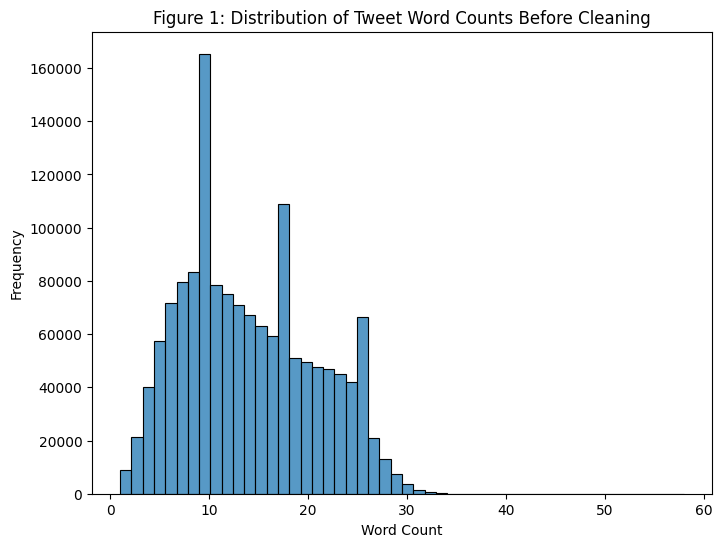

In [15]:
# --- Visualizations for Report ---
# Figure 1: Histogram of Tweet Word Counts Before Cleaning
plt.figure(figsize=(8, 6))
sns.histplot(df['tweet'].apply(lambda x: len(x.split())), bins=50)
plt.title('Figure 1: Distribution of Tweet Word Counts Before Cleaning')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('plots/figure1_word_count_before.png')
plt.show()

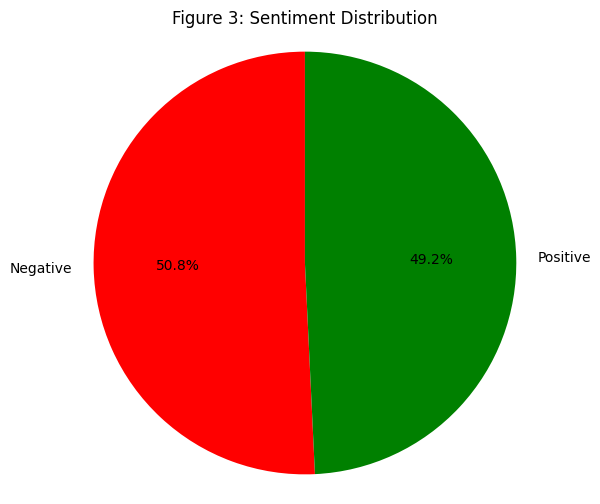

In [16]:
# Figure 3: Pie Chart of Sentiment Distribution
plt.figure(figsize=(6, 6))
sentiment_counts = df['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['red', 'green'], startangle=90)
plt.title('Figure 3: Sentiment Distribution')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('plots/figure3_sentiment_distribution_pie.png')
plt.show()

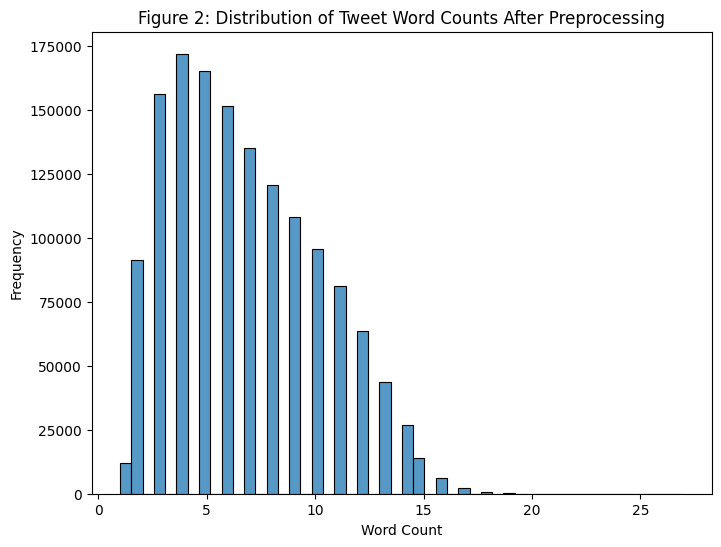

In [17]:
# Figure 2: Histogram of Tweet Word Counts After Preprocessing
plt.figure(figsize=(8, 6))
sns.histplot(df['tweet_length'], bins=50)
plt.title('Figure 2: Distribution of Tweet Word Counts After Preprocessing')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('plots/figure2_word_count_after.png')
plt.show()

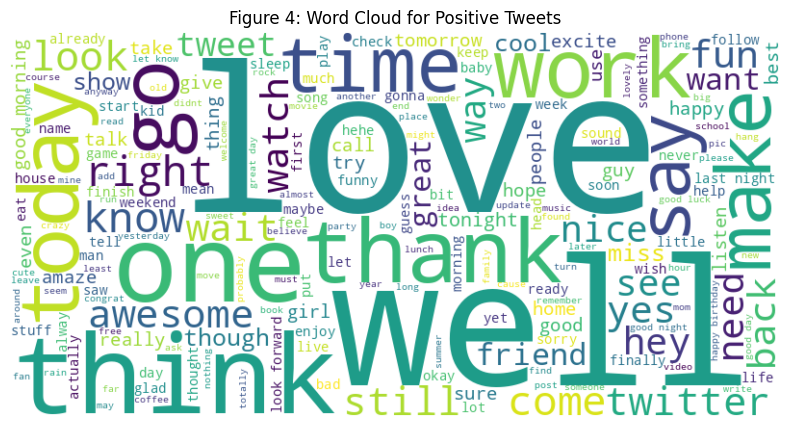

In [18]:
# Figure 4 : Word Clouds for Positive
positive_tweets = ' '.join(df[df['sentiment'] == 'Positive']['clean_tweet'])
negative_tweets = ' '.join(df[df['sentiment'] == 'Negative']['clean_tweet'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Figure 4: Word Cloud for Positive Tweets')
plt.savefig('plots/figure4_wordcloud_positive.png')
plt.show()

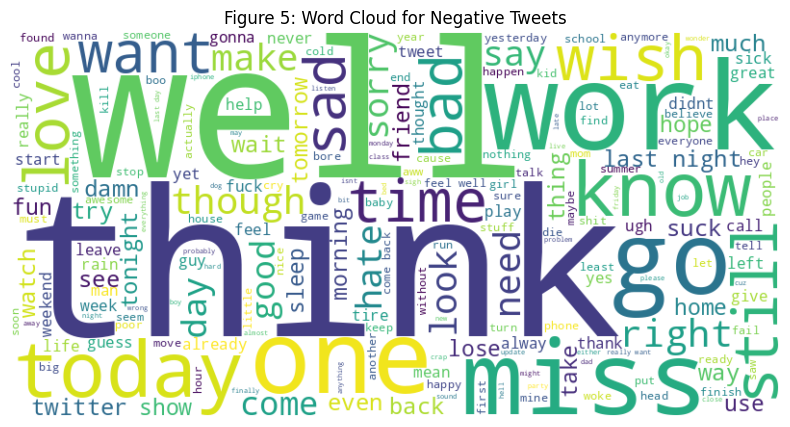

In [19]:
# Figure  5: Word Clouds for  Negative Tweets
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Figure 5: Word Cloud for Negative Tweets')
plt.savefig('plots/figure5_wordcloud_negative.png')
plt.show()

In [20]:
# Splitting data based on label counts
df_pos = df[df['label'] == 1].sample(n=250000, random_state=42, replace=True)
df_neg = df[df['label'] == 0].sample(n=250000, random_state=42, replace=True)

In [21]:
# Concatenate the sampled dataframes
df_balanced = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataframe shape: {df.shape}")
print(f"Balanced dataframe shape: {df_balanced.shape}")
print("Balanced dataframe label counts:")
print(df_balanced['label'].value_counts())

Original dataframe shape: (1446756, 9)
Balanced dataframe shape: (500000, 9)
Balanced dataframe label counts:
label
1    250000
0    250000
Name: count, dtype: int64


In [22]:
df_balanced.head()

,sentiment,ids,date,flag,user,tweet,label,clean_tweet,tweet_length
0,Positive,1553336395,Sat Apr 18 13:59:47 PDT 2009,NO_QUERY,rokdiesel,@stinger_wifey ok i just saw your Longhorn com...,1,saw longhorn comment seasalt must brain husban...,9
1,Positive,1794011502,Thu May 14 04:41:57 PDT 2009,NO_QUERY,Katie_Traut,@StephenR13 It's a tricky game. Facebook is wo...,1,tricky game facebook bad though,5
2,Positive,2187138136,Mon Jun 15 19:50:42 PDT 2009,NO_QUERY,kerrinsuzanne,@mccanner great job Erin! way to scoop everyon...,1,great job erin way scoop everyone else,7
3,Positive,1755062086,Sun May 10 08:09:17 PDT 2009,NO_QUERY,jessicaigyarto,@sarahisrad I expect picturess!,1,expect picturess,2
4,Negative,2203892784,Wed Jun 17 00:47:47 PDT 2009,NO_QUERY,rereality,"waiting for iPhone 3.0, i freaking woke up at ...",0,wait iphone freak woke eye hurt,6


In [23]:
# --- Data Preparation ---
# Vectorize text for ML/DL models
vectorizer = CountVectorizer(max_features=1000)
X_ml = vectorizer.fit_transform(df_balanced['clean_tweet'])
y_ml = df_balanced['label']

In [24]:
from sklearn.model_selection import train_test_split,GridSearchCV

# Train-test split
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_ml, y_ml, test_size=0.2, random_state=42, stratify=y_ml)

# Scale features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_ml)
X_test_scaled = scaler.transform(X_test_ml)

# Convert to dense tensors for Keras MLP
X_train_dense = tf.convert_to_tensor(X_train_scaled.toarray(), dtype=tf.float32)
X_test_dense = tf.convert_to_tensor(X_test_scaled.toarray(), dtype=tf.float32)
y_train_dense = tf.convert_to_tensor(y_train_ml.values, dtype=tf.float32)
y_test_dense = tf.convert_to_tensor(y_test_ml.values, dtype=tf.float32)

In [25]:
# --- ML Models with Hyperparameter Tuning ---
models = {
    'Logistic Regression': GridSearchCV(LogisticRegression(max_iter=500, solver='saga'),
                                       param_grid={'C': [0.1, 1, 10]}, cv=3),
    'Naive Bayes': GridSearchCV(MultinomialNB(),
                                param_grid={'alpha': [0.1, 0.5, 1.0]}, cv=3),
    'SVM': GridSearchCV(LinearSVC(),
                        param_grid={'C': [0.1, 1, 10]}, cv=3)
}


Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 1}

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.70      0.73     50000
           1       0.72      0.77      0.74     50000

    accuracy                           0.73    100000
   macro avg       0.74      0.73      0.73    100000
weighted avg       0.74      0.73      0.73    100000



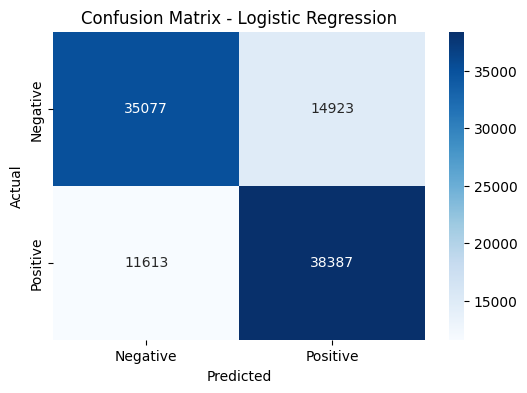


Training Naive Bayes...
Best parameters for Naive Bayes: {'alpha': 1.0}

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.72     50000
           1       0.73      0.71      0.72     50000

    accuracy                           0.72    100000
   macro avg       0.72      0.72      0.72    100000
weighted avg       0.72      0.72      0.72    100000



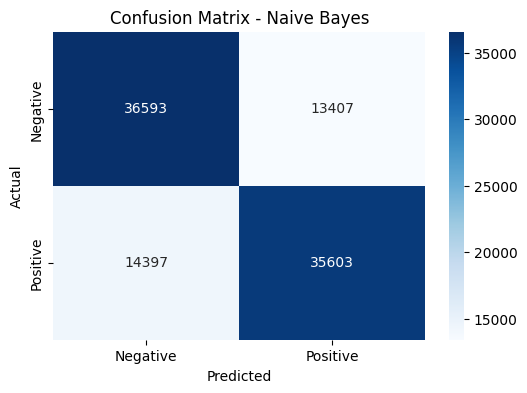


Training SVM...
Best parameters for SVM: {'C': 0.1}

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.68      0.72     50000
           1       0.71      0.79      0.75     50000

    accuracy                           0.73    100000
   macro avg       0.74      0.73      0.73    100000
weighted avg       0.74      0.73      0.73    100000



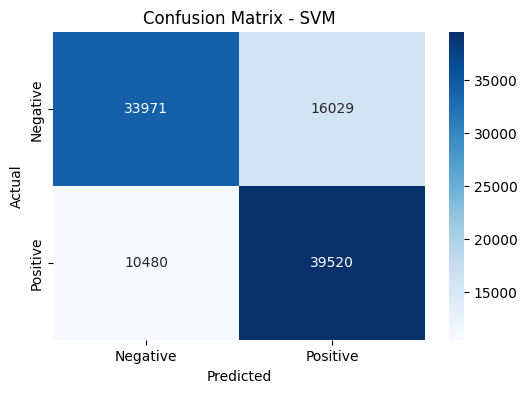

In [26]:
ml_results = []
for name, clf in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()

    # Train model
    if name == 'Naive Bayes':
        clf.fit(X_train_ml, y_train_ml)
        y_pred = clf.predict(X_test_ml)
        train_pred = clf.predict(X_train_ml)
    else:
        clf.fit(X_train_scaled, y_train_ml)
        y_pred = clf.predict(X_test_scaled)
        train_pred = clf.predict(X_train_scaled)

    # Evaluate
    train_acc = accuracy_score(y_train_ml, train_pred)
    test_acc = accuracy_score(y_test_ml, y_pred)
    test_f1 = classification_report(y_test_ml, y_pred, output_dict=True)['macro avg']['f1-score']

    # Best hyperparameters
    print(f"Best parameters for {name}: {clf.best_params_}")

    # Inference time
    inference_start = time.time()
    for _ in range(100):
        if name == 'Naive Bayes':
            clf.predict(X_test_ml[:10000])
        else:
            clf.predict(X_test_scaled[:10000])
    inference_time = (time.time() - inference_start) / 100 * 1000  # ms for 10,000 samples

    ml_results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Test F1': test_f1,
        'Inference Time (ms)': inference_time
    })

    # Classification report and confusion matrix
    print(f"\n{name} Classification Report:\n", classification_report(y_test_ml, y_pred))
    cm = confusion_matrix(y_test_ml, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'plots/cm_{name.lower().replace(" ", "_")}.png')
    plt.show()


Training Keras MLP...
Epoch 1/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 63s 3ms/step - accuracy: 0.7014 - loss: 0.5787 - val_accuracy: 0.7294 - val_loss: 0.5455
Epoch 2/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.7347 - loss: 0.5354 - val_accuracy: 0.7326 - val_loss: 0.5446
Epoch 3/3
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 62s 3ms/step - accuracy: 0.7406 - loss: 0.5241 - val_accuracy: 0.7348 - val_loss: 0.5399


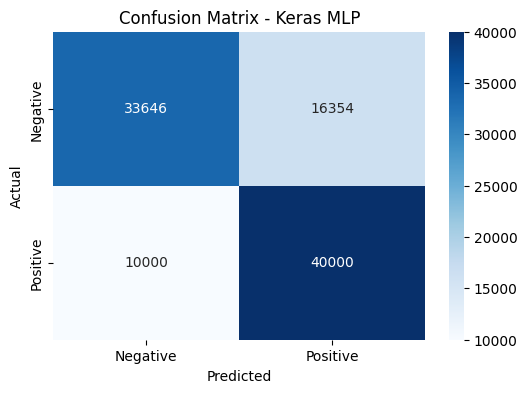


=== Model Performance Summary ===
                 Model  Train Accuracy  Test Accuracy  Test F1  \
0  Logistic Regression          0.7367         0.7346   0.7343   
1          Naive Bayes          0.7245         0.7220   0.7219   
2                  SVM          0.7358         0.7349   0.7341   
3            Keras MLP          0.7507         0.7365   0.7354   

   Inference Time (ms)  
0               1.3670  
1               1.2329  
2               0.9476  
3            1188.0089  


In [27]:
# --- Keras MLP ---
print("\nTraining Keras MLP...")
tf.keras.backend.clear_session()  # Clear previous session

# Force CPU for all operations to avoid device mismatch
with tf.device('/CPU:0'):
    mlp_model = Sequential([
        Input(shape=(X_train_dense.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    mlp_model.fit(X_train_dense, y_train_dense, validation_split=0.2, epochs=3, batch_size=16, verbose=1)

    # Evaluate
    loss, test_acc = mlp_model.evaluate(X_test_dense, y_test_dense, batch_size=16, verbose=0)
    y_pred_probs = mlp_model.predict(X_test_dense, batch_size=16, verbose=0)
    y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()
    test_f1 = classification_report(y_test_dense, y_pred_classes, output_dict=True)['macro avg']['f1-score']

    # Inference time
    inference_start = time.time()
    for _ in range(100):
        mlp_model.predict(X_test_dense[:10000], batch_size=16, verbose=0)
    inference_time = (time.time() - inference_start) / 100 * 1000  # ms for 10,000 samples

    ml_results.append({
        'Model': 'Keras MLP',
        'Train Accuracy': mlp_model.evaluate(X_train_dense, y_train_dense, batch_size=16, verbose=0)[1],
        'Test Accuracy': test_acc,
        'Test F1': test_f1,
        'Inference Time (ms)': inference_time
    })

# Confusion matrix
cm = confusion_matrix(y_test_dense, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Keras MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/cm_keras_mlp.png')
plt.show()

# Display results summary
results_df = pd.DataFrame(ml_results)
print("\n=== Model Performance Summary ===")
print(results_df.round(4))

In [28]:
test_texts = [
        "I love this product! It's amazing and works perfectly!",
        "This is terrible. Worst experience ever. Very disappointed.",
        "The service was okay, nothing special but not bad either.",
        "Absolutely fantastic! Highly recommend to everyone!",
        "Not sure about this. Mixed feelings about the quality.",
        "At this speed, I might actually finish my degree before the page loads.",
        "I bought a laptop and it worked for only 2 days very well"
    ]

In [29]:
# Function to get predictions from all models
def get_all_predictions(text):
    # Preprocess the text
    clean_text = preprocess_tweet(text)

    # Vectorize for ML models
    text_vectorized = vectorizer.transform([clean_text])
    text_scaled = scaler.transform(text_vectorized)
    text_dense = tf.convert_to_tensor(text_scaled.toarray(), dtype=tf.float32)

    predictions = {}

    # ML Model predictions
    for name, model in models.items():
        if name == 'Naive Bayes':
            pred_class = model.predict(text_vectorized)[0]
        else:
            pred_class = model.predict(text_scaled)[0]

        sentiment = 'Positive' if pred_class == 1 else 'Negative'
        predictions[name] = sentiment

    # Keras MLP prediction
    with tf.device('/CPU:0'):
        mlp_pred_proba = mlp_model.predict(text_dense, verbose=0)[0][0]
    pred_class = 'Positive' if mlp_pred_proba > 0.5 else 'Negative'
    predictions['Keras MLP'] = pred_class

    return predictions

# Display predictions for each test text
for i, text in enumerate(test_texts, 1):
    print(f"\nText {i}: {text}")
    predictions = get_all_predictions(text)

    for model_name, sentiment in predictions.items():
        print(f"{model_name:<20}: {sentiment}")

print("\n" + "=" * 80)


Text 1: I love this product! It's amazing and works perfectly!
Logistic Regression : Positive
Naive Bayes         : Positive
SVM                 : Positive
Keras MLP           : Positive

Text 2: This is terrible. Worst experience ever. Very disappointed.
Logistic Regression : Negative
Naive Bayes         : Negative
SVM                 : Negative
Keras MLP           : Negative

Text 3: The service was okay, nothing special but not bad either.
Logistic Regression : Negative
Naive Bayes         : Negative
SVM                 : Negative
Keras MLP           : Negative

Text 4: Absolutely fantastic! Highly recommend to everyone!
Logistic Regression : Positive
Naive Bayes         : Positive
SVM                 : Positive
Keras MLP           : Positive

Text 5: Not sure about this. Mixed feelings about the quality.
Logistic Regression : Positive
Naive Bayes         : Positive
SVM                 : Positive
Keras MLP           : Positive

Text 6: At this speed, I might actually finish my degr

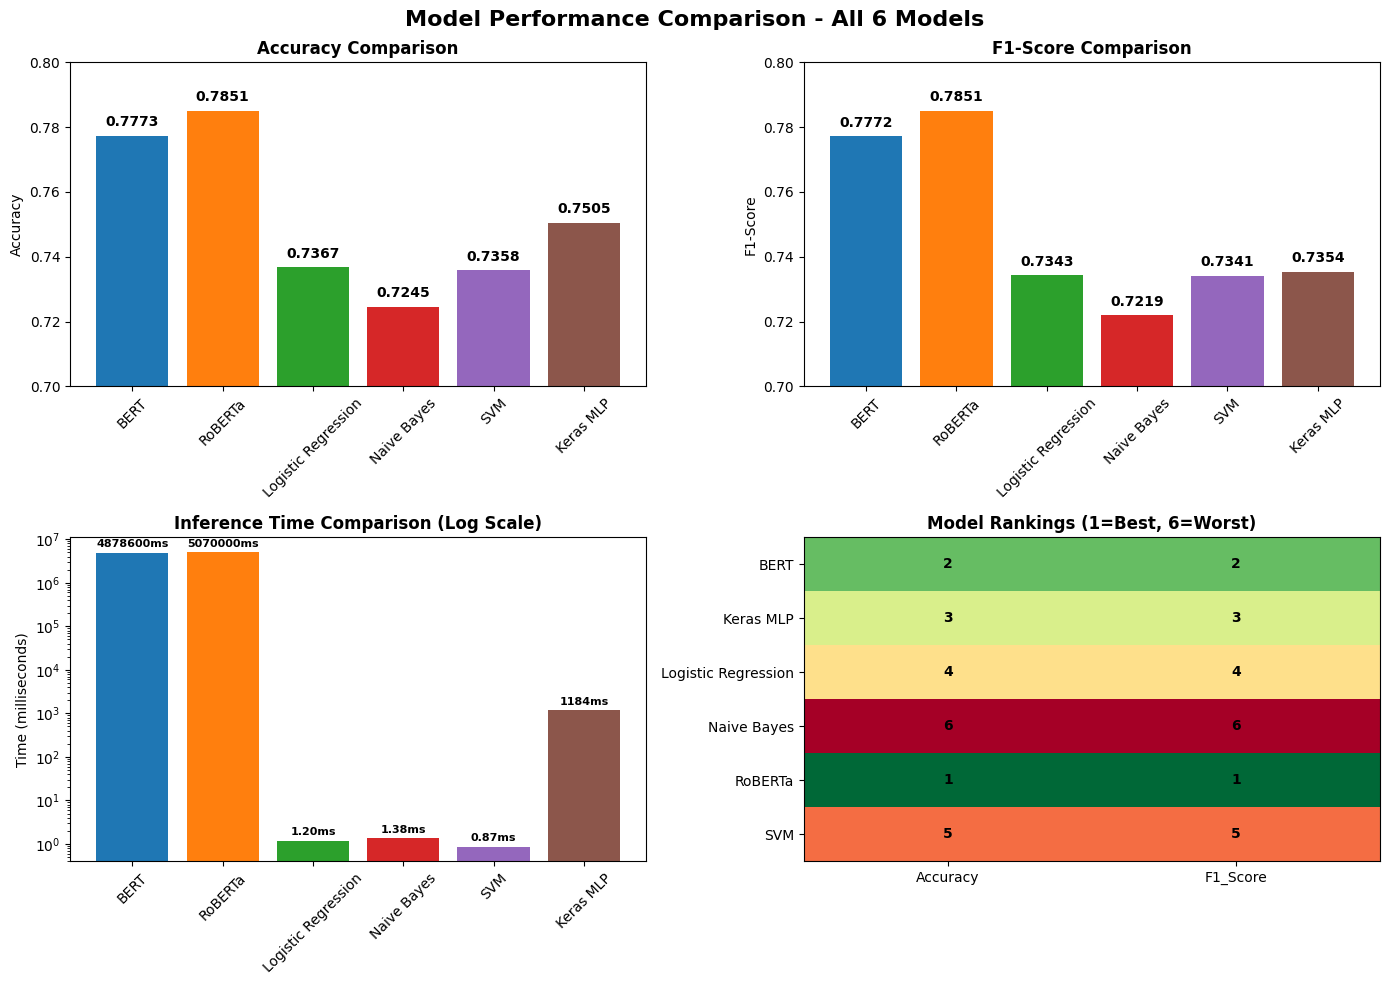

MODEL PERFORMANCE SUMMARY
Model                Accuracy   F1-Score   Inference Time 
------------------------------------------------------------
BERT                 0.7773     0.7772     81.31s         
RoBERTa              0.7851     0.7851     84.50s         
Logistic Regression  0.7367     0.7343     1.195ms        
Naive Bayes          0.7245     0.7219     1.375ms        
SVM                  0.7358     0.7341     0.871ms        
Keras MLP            0.7505     0.7354     1184.148ms     

BEST PERFORMERS:
Best Accuracy: RoBERTa (0.7851)
Best F1-Score: RoBERTa (0.7851)
Fastest Inference: SVM (0.871ms)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Model performance data from results
models_data = {
    'Model': ['BERT', 'RoBERTa', 'Logistic Regression', 'Naive Bayes', 'SVM', 'Keras MLP'],
    'Accuracy': [0.7773, 0.7851, 0.7367, 0.7245, 0.7358, 0.7505],
    'F1_Score': [0.7772, 0.7851, 0.7343, 0.7219, 0.7341, 0.7354],
    'Inference_Time': [81.31 * 60 * 1000, 84.50 * 60 * 1000, 1.1954, 1.3754, 0.8712, 1184.1481]  # Converted to ms
}

# Convert to DataFrame
df = pd.DataFrame(models_data)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison - All 6 Models', fontsize=16, fontweight='bold')

# Color palette for models
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# 1. Accuracy Comparison (00)
axes[0, 0].bar(df['Model'], df['Accuracy'], color=colors)
axes[0, 0].set_title('Accuracy Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0.7, 0.8)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(df['Accuracy']):
    axes[0, 0].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. F1-Score Comparison (01)
axes[0, 1].bar(df['Model'], df['F1_Score'], color=colors)
axes[0, 1].set_title('F1-Score Comparison', fontweight='bold')
axes[0, 1].set_ylabel('F1-Score')
axes[0, 1].set_ylim(0.7, 0.8)
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(df['F1_Score']):
    axes[0, 1].text(i, v + 0.002, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Inference Time Comparison (10) - Log scale due to wide range
inference_times_ms = df['Inference_Time']  # Already in ms
axes[1, 0].bar(df['Model'], inference_times_ms, color=colors)
axes[1, 0].set_title('Inference Time Comparison (Log Scale)', fontweight='bold')
axes[1, 0].set_ylabel('Time (milliseconds)')
axes[1, 0].set_yscale('log')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(inference_times_ms):
    if v > 1000:
        axes[1, 0].text(i, v * 1.2, f'{v:.0f}ms', ha='center', va='bottom', fontweight='bold', fontsize=8)
    else:
        axes[1, 0].text(i, v * 1.2, f'{v:.2f}ms', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 4. Model Rankings Heatmap (11)
performance_metrics = ['Accuracy', 'F1_Score']
ranking_data = []
for metric in performance_metrics:
    sorted_models = df.sort_values(metric, ascending=False)
    for rank, (idx, row) in enumerate(sorted_models.iterrows(), 1):
        ranking_data.append({'Metric': metric, 'Model': row['Model'], 'Rank': rank, 'Value': row[metric]})

ranking_df = pd.DataFrame(ranking_data)
pivot_ranking = ranking_df.pivot(index='Model', columns='Metric', values='Rank')

# Create heatmap for rankings
im = axes[1, 1].imshow(pivot_ranking.values, cmap='RdYlGn_r', aspect='auto')
axes[1, 1].set_title('Model Rankings (1=Best, 6=Worst)', fontweight='bold')
axes[1, 1].set_xticks(range(len(performance_metrics)))
axes[1, 1].set_xticklabels(performance_metrics)
axes[1, 1].set_yticks(range(len(df['Model'])))
axes[1, 1].set_yticklabels(pivot_ranking.index)

# Add rank numbers to heatmap
for i in range(len(pivot_ranking.index)):
    for j in range(len(performance_metrics)):
        text = axes[1, 1].text(j, i, int(pivot_ranking.iloc[i, j]),
                              ha="center", va="center", color="black", fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'Inference Time':<15}")
print("-"*60)
for i, row in df.iterrows():
    time_str = f"{row['Inference_Time'] / (60 * 1000):.2f}s" if row['Model'] in ['BERT', 'RoBERTa'] else f"{row['Inference_Time']:.3f}ms"
    print(f"{row['Model']:<20} {row['Accuracy']:<10.4f} {row['F1_Score']:<10.4f} {time_str:<15}")

print("\nBEST PERFORMERS:")
print(f"Best Accuracy: {df.loc[df['Accuracy'].idxmax(), 'Model']} ({df['Accuracy'].max():.4f})")
print(f"Best F1-Score: {df.loc[df['F1_Score'].idxmax(), 'Model']} ({df['F1_Score'].max():.4f})")
print(f"Fastest Inference: {df.loc[df['Inference_Time'].idxmin(), 'Model']} ({df['Inference_Time'].min():.3f}ms)")